# HW 6 Module Assignment 

#### 1. Aggregate the tornado data over the following states into a monthly count of tornadoes: Illinois

In [1]:
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# import tornado count dataset
tors = pd.read_csv('https://www.spc.noaa.gov/wcm/data/1950-2021_actual_tornadoes.csv')
tors.rename(columns={'date': 'Date'}, inplace=True)
# create Date index
tors.Date = pd.to_datetime(tors.Date)
tors = tors.set_index('Date')
# subset Illinois tornadoes
tors.query('st == "IL"', inplace=True)

In [3]:
# resample tornado counts to monthly freq
tors_il = tors.resample("MS").count().iloc[:,1:2]
tors_il.head()

,yr
Date,
1950-01-01,2
1950-02-01,0
1950-03-01,1
1950-04-01,0
1950-05-01,0


#### 2. Merge this monthly tornado dataset with the ENSO, PDO, NAO, and AO dataframe created in Module 4 Notebook 1.

In [5]:
# import teleconnection datasets 
enso = pd.read_csv('https://www.atmos.illinois.edu/~snesbitt/soi.dat',sep=r'\s+',header=None,skiprows=4,skipfooter=0, engine='python')
pdo = pd.read_csv('https://www.ncei.noaa.gov/pub/data/cmb/ersst/v5/index/ersst.v5.pdo.dat',sep=r'\s+',header=None,skiprows=2, engine='python')
nao = pd.read_csv('https://www.cpc.ncep.noaa.gov/products/precip/CWlink/pna/norm.nao.monthly.b5001.current.ascii.table',sep=r'\s+',header=None,skiprows=1, engine='python')
ao = pd.read_csv('https://www.cpc.ncep.noaa.gov/products/precip/CWlink/daily_ao_index/monthly.ao.index.b50.current.ascii.table',sep=r'\s+',header=None,skiprows=1, engine='python')

In [6]:
'''Create new dataframes for monthly row-based data for each teleconnection'''
enso_new=pd.DataFrame()
nao_new=pd.DataFrame()
pdo_new=pd.DataFrame()
ao_new=pd.DataFrame()
# create monthly dates from each dataset
enso_new['Date']=pd.date_range(start=datetime.datetime(enso[0].iloc[0], 1, 1),
                               end=datetime.datetime(enso[0].iloc[-1], 12, 1),
                               freq="MS")
nao_new['Date'] = pd.date_range(start=datetime.datetime(nao[0].iloc[0],1,1),
                                end=datetime.datetime(nao[0].iloc[-1],12,1),
                                freq="MS")
pdo_new['Date'] = pd.date_range(start=datetime.datetime(pdo[0].iloc[0],1,1),
                                end=datetime.datetime(pdo[0].iloc[-1],12,1),
                                freq="MS")
ao_new['Date'] = pd.date_range(start=datetime.datetime(ao[0].iloc[0],1,1),
                               end=datetime.datetime(ao[0].iloc[-1],12,1),
                               freq="MS")
# set up new index with monthly dates
enso_new = enso_new.set_index('Date')
nao_new = nao_new.set_index('Date')
pdo_new = pdo_new.set_index('Date')
ao_new = ao_new.set_index('Date')
# append teleconnection index values
enso_new['ENSO']=enso.loc[:,1:].stack().values
nao_new['NAO']=nao.loc[:,1:].stack(dropna=False).values
pdo_new['PDO']=pdo.loc[:,1:].stack(dropna=False).values
ao_new['AO']=ao.loc[:,1:].stack(dropna=False).values

/tmp/ipykernel_2161/2231746585.py:26: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  nao_new['NAO']=nao.loc[:,1:].stack(dropna=False).values
/tmp/ipykernel_2161/2231746585.py:27: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  pdo_new['PDO']=pdo.loc[:,1:].stack(dropna=False).values
/tmp/ipykernel_2161/2231746585.py:28: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  

In [7]:
# merge 4 teleconnection and monthly tornado count dataframes
df = pd.merge(enso_new, pdo_new, left_index=True, right_index=True)
df = pd.merge(df, nao_new, left_index=True, right_index=True)
df = pd.merge(df, ao_new, left_index=True, right_index=True)
df = pd.merge(df, tors_il, left_index=True, right_index=True)
# rename tornado count column
df = df.rename(columns={'yr': 'tornado_cnt'})
# preview final merged df 
df.head()

,ENSO,PDO,NAO,AO,tornado_cnt
Date,,,,,
1951-01-01,1.5,-1.19,0.08,-0.085,0
1951-02-01,0.9,-1.52,0.70,-0.400,0
1951-03-01,-0.1,-1.72,-1.02,-1.934,0
1951-04-01,-0.3,-1.35,-0.22,-0.776,0
1951-05-01,-0.7,-1.29,-0.59,-0.863,0


#### 3. Create a random forest regression model and use features that include the 4 climate indices to predict the monthly number of tornadoes. Create a scatter plot of the predicted and observed number of tornadoes over these states. Report the correlation coefficient and RMSE of your model.

/home/mheslar2/envs/xarray-climate/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Best Random Forest Regressor R^2: -0.11219306266979845
Best Random Forest Regressor RMSE: 6.195106913557679


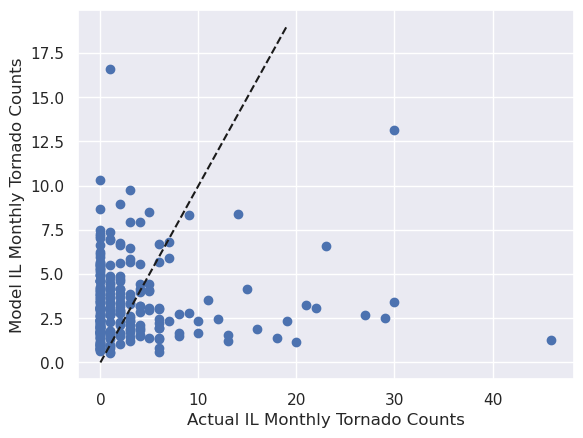

In [ ]:
import seaborn as sns; sns.set()
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error, r2_score

# split the data for 70% training dataset
feats = df.iloc[:, range(0, df.shape[1]-1)]
target = df.iloc[:, df.shape[1]-1]
x_train, x_test, y_train, y_test = train_test_split(
    feats, target, random_state=0, train_size=0.7)
# fit and get predictions from random forest model
model = RandomForestRegressor(
    bootstrap = True,
    max_depth = 40,
    max_features = "sqrt",  
    n_estimators = 800)
model.fit(x_train, y_train)
y_model = model.predict(x_test)

# scatter plot comparison of model and true tornado counts
plt.plot(range(20), range(20), 'k--')
plt.scatter(y_test, y_model)
plt.xlabel('Actual IL Monthly Tornado Counts')
plt.ylabel('Model IL Monthly Tornado Counts')

# check accuracy of testing data (R^2 and RMSE)
print('Best Random Forest Regressor R^2:', str(model.score(x_test.to_numpy(), y_test.to_numpy())))
print('Best Random Forest Regressor RMSE:', str(root_mean_squared_error(y_test.to_numpy(), y_model)))

#### 4. Create a one-hot encoding for the month of the year. Repeat the scatterplot and compare the RMSE and correlation coefficient values.

In [16]:
from sklearn.preprocessing import OneHotEncoder

# add month column and convert tornado count to float dtype
df['month'] = df.index.month
df.tornado_cnt = np.float16(df.tornado_cnt)

# extract "encoded" month column and run OHE 
encoded_col = df.select_dtypes(include=['int']).columns.tolist()
encoder = OneHotEncoder(sparse_output=False)
ohe = encoder.fit_transform(df[encoded_col])
# extract OHE columns and append back to original dataframe 
one_hot_df = pd.DataFrame(ohe, columns=encoder.get_feature_names_out(encoded_col))
df_ohe = pd.concat([df.reset_index().drop(encoded_col, axis=1), one_hot_df], axis=1)

# move torndao_cnt column to last position
last_column = df_ohe.pop('tornado_cnt')
df_ohe.insert(df_ohe.shape[1], 'tornado_cnt', last_column)

# print preview of encoded df 
df_ohe.head()

/home/mheslar2/envs/xarray-climate/lib/python3.13/site-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


,Date,ENSO,PDO,NAO,AO,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,tornado_cnt
0,1951-01-01,1.5,-1.19,0.08,-0.085,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1951-02-01,0.9,-1.52,0.70,-0.400,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1951-03-01,-0.1,-1.72,-1.02,-1.934,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1951-04-01,-0.3,-1.35,-0.22,-0.776,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1951-05-01,-0.7,-1.29,-0.59,-0.863,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


/home/mheslar2/envs/xarray-climate/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Best Random Forest Regressor R^2: 0.025687927856859694
Best Random Forest Regressor RMSE: 5.798394458986208


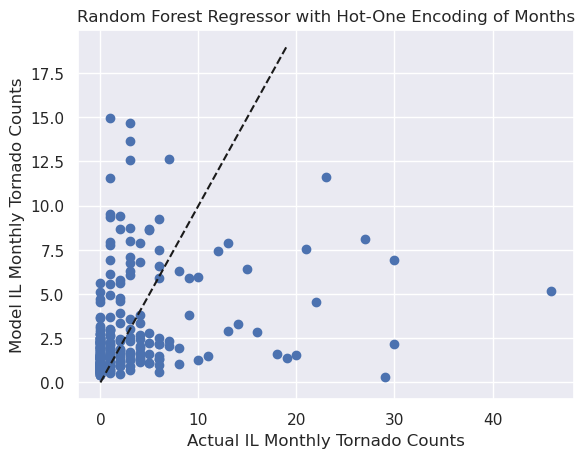

In [17]:
# split the data for 70% training dataset
feats = df_ohe.iloc[:, range(1, df_ohe.shape[1]-1)]
target = df_ohe.iloc[:, df_ohe.shape[1]-1]
x_train, x_test, y_train, y_test = train_test_split(
    feats, target, random_state=0, train_size=0.7)

# random forest model and predicted tornado counts
model = RandomForestRegressor(
    bootstrap = True,
    max_depth = 40,
    max_features = "sqrt",  
    n_estimators = 800)
model.fit(x_train, y_train)
y_model = model.predict(x_test)

# scatter plot comparison of model and true tornado counts
plt.plot(range(20), range(20), 'k--')
plt.scatter(y_test, y_model)
plt.xlabel('Actual IL Monthly Tornado Counts')
plt.ylabel('Model IL Monthly Tornado Counts')
plt.title("Random Forest Regressor with Hot-One Encoding of Months")

# check accuracy of testing data (R^2 and RMSE)
print('Best Random Forest Regressor R^2:', str(model.score(x_test.to_numpy(), y_test.to_numpy())))
print('Best Random Forest Regressor RMSE:', str(root_mean_squared_error(y_test.to_numpy(), y_model)))

#### 5. Perform a feature importance and multipass permutation analysis of your features.

We can observe the teleconnections account for the majority of the feature importance with the Date-Encoded Random Forest model, but the months of May and June show some significance of 5-10%.

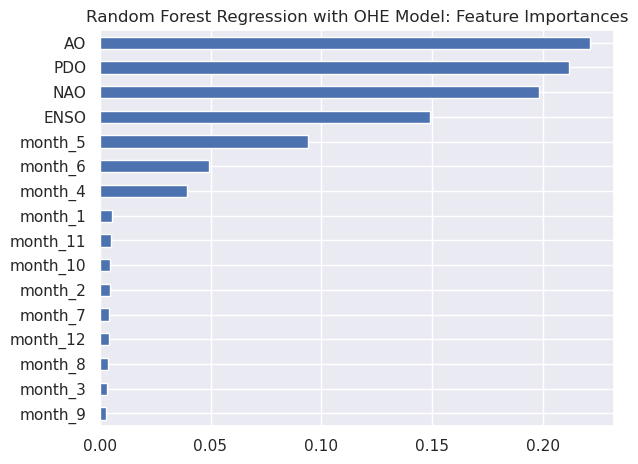

In [12]:
# get feature names
feature_names = model.feature_names_in_
# extract feature importances from RFR-OHE model
feat_importances = pd.Series(
    model.feature_importances_, index=feature_names
).sort_values(ascending=True)
# plot feature importances
ax = feat_importances.plot.barh()
ax.set_title("Random Forest Regression with OHE Model: Feature Importances")
ax.figure.tight_layout()

We can see the late spring months and only ENSO and AO teleconnections show the largest decrease in accuracy scores, indicating they are the most important variables to model the tornado counts in Illinois and meet our expectations with tornado season occurring between April and June.

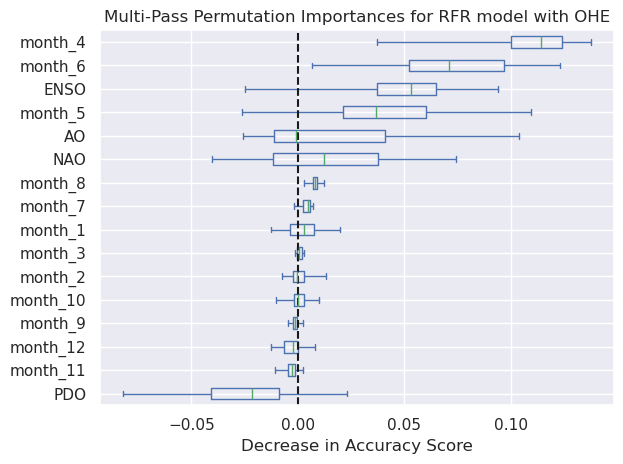

In [24]:
from sklearn.inspection import permutation_importance

# run multi-pass permutation test 
result = permutation_importance(
    model, x_test, y_test, 
    n_repeats=20, random_state=42
)

# sort and plot the permutation importance 
sorted_importances_idx = result.importances_mean.argsort()
importances = pd.DataFrame(
    result.importances[sorted_importances_idx].T,
    columns=x_test.columns[sorted_importances_idx],
)
ax = importances.plot.box(vert=False, whis=10)
ax.set_title("Multi-Pass Permutation Importances for RFR model with OHE")
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Decrease in Accuracy Score")
ax.figure.tight_layout()

#### 6. Create a SHAP Summary Plot showing feature importance and feature effects.

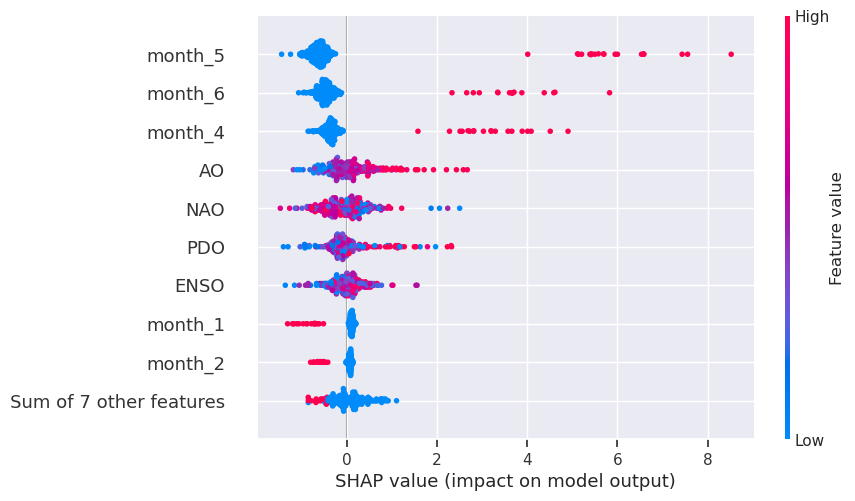

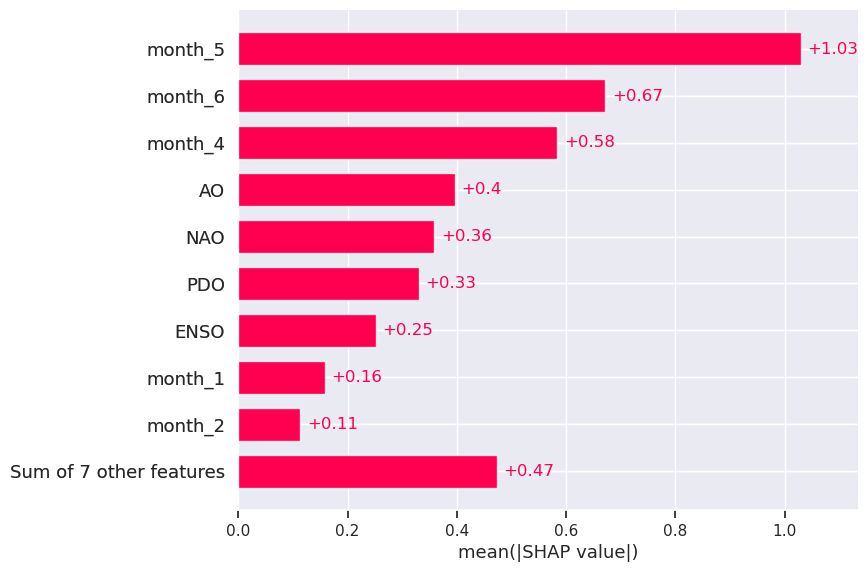

In [35]:
# import SHAP library and set up javascript env
import shap
shap.initjs()

# create Explainer object and calculate SHAP values
explainer = shap.Explainer(model)
shap_values = explainer(x_test)  # shap.Explanation

# create beeswarm and bar plots to summarize SHAP values
shap.plots.beeswarm(shap_values, max_display=10)
shap.plots.bar(shap_values, max_display=10)

#### 7. Create a SHAP Feature Dependence for the ENSO index.

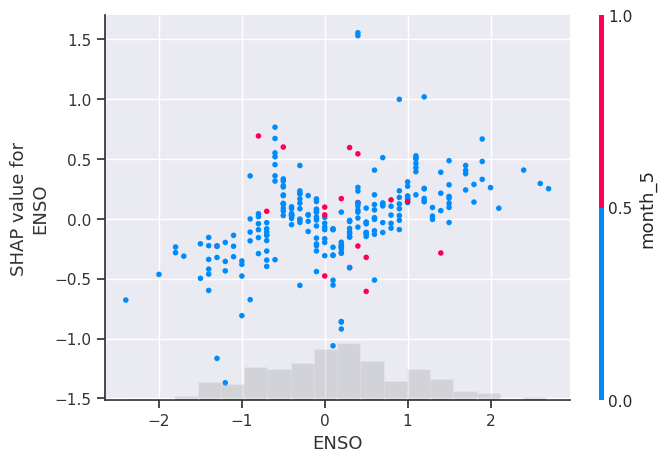

In [ ]:
# ENSO dependence on SHAP value of month of May (most significant feature)
shap.plots.scatter(shap_values[:, 'ENSO'], color=shap_values[:, 'month_5'])

#### 8. Any observations on the importance of the various features in your model from the XAI techniques you tried?

The late spring months of April to June are the most significant features for the model in the SHAP summary plots, namely their high SHAP values for those months in the beeswarm plot and the highest mean SHAP values in the bar plot. The teleconnections are somewhat important features to the model and generally show that positive teleconnection values, except for NAO, lead to higher tornado counts in the beeswarm plot.

The ENSO dependence plot for the most important feature, the month of May, seems to support the notion of a weak anti-correlation between the month of May and ENSO values, such that more tornadoes may form in the month of May in the negative ENSO phase.

